In [ ]:
# Get the Dataset
# !git clone https://github.com/ML4SCI-SLC/SLC_Data.git
%cd SLC_Data

In [2]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Files with substructure

Samples with substructure: 


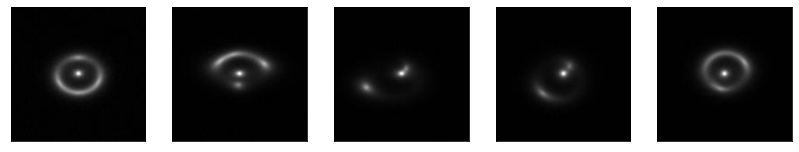

In [3]:
path_sub = './lenses/sub' # Path to samples with substructure 
files_sub = [os.path.join(path_sub, f) for f in os.listdir(path_sub) if f.endswith(".jpg")]
random.shuffle(files_sub)

# Number of samples to display per class
n = 5

# Plot the samples with substructure 
print('Samples with substructure: ')
i = 1
plt.rcParams['figure.figsize'] = [14, 14]
for image in files_sub[:n]:
    ax = plt.subplot(2,n,i)
    plt.imshow(cv2.imread(image,0), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

### The following is for the files with no substructure

Samples with no substructure: 


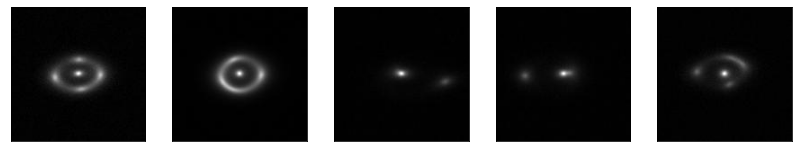

In [4]:
path_nosub = './lenses/no_sub' # Path to samples with no substructure 
files_nosub = [os.path.join(path_nosub, f) for f in os.listdir(path_nosub) if f.endswith(".jpg")]
random.shuffle(files_nosub)

# Plot the samples with no substructure 
print('Samples with no substructure: ')
i = 1
for image in files_nosub[:n]:
    ax = plt.subplot(2,n,i+n)
    plt.imshow(cv2.imread(image,0), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

In [5]:
# Data augmentation 
transform = transforms.Compose([transforms.Grayscale(),
                                        transforms.Resize((150, 150)),
                                        transforms.RandomAffine(degrees=(0,90), translate=(0.2,0.2)),
                                        transforms.ToTensor()])

batch_size = 100
data_path = './lenses' # Path to input data
data = datasets.ImageFolder(data_path, transform = transform)
# print("Classes: " + str(data.class_to_idx))
# data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)

# x = []
# y = []
# for samples, labels in data_loader:
#     x.append(samples.numpy())
#     y.append(labels.numpy())
# x = np.asarray(x)
# y = np.asarray(y)

# print('Data Processed!')
# print('Shape of the Data: ' + str(x.shape))
# print('Shape of the labels: ' + str(y.shape))

In [9]:
print("Classes: ",(data.class_to_idx))
data_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle=True)

Classes:  {'no_sub': 0, 'sub': 1}


In [10]:
data.classes

['no_sub', 'sub']

In [11]:


no_sub = []
sub = []
for samples, labels in data_loader:
    if labels[0] == 0:
        no_sub.append(samples.numpy()[0])
    else:
        sub.append(samples.numpy()[0])
no_sub = np.asarray(no_sub)
sub = np.asarray(sub)

print (no_sub.shape)
print (sub.shape)


no_sub = no_sub.reshape(4500, 150, 150, 1)
sub = sub.reshape(4500, 150, 150, 1)


(4500, 1, 150, 150)
(4500, 1, 150, 150)


In [12]:
print (no_sub.shape)
print (sub.shape)

(4500, 150, 150, 1)
(4500, 150, 150, 1)


In [13]:
# no_sub = no_sub.reshape(batch_size,-1,1,150,150)
# sub = sub.reshape(batch_size,-1,1,150,150)

# Hold-out validation
split = 0.8
x_train = no_sub[:int(no_sub.shape[0]*split)]

# Validation samples
x_test1 = no_sub[int(no_sub.shape[0]*split):]
x_test2 = sub[int(sub.shape[0]*split):]

print("Shape of no substructure data: " + str(no_sub.shape))
print("Shape of substructure data: " + str(sub.shape))

Shape of no substructure data: (4500, 150, 150, 1)
Shape of substructure data: (4500, 150, 150, 1)


In [14]:
print (x_train.shape)
print (x_test1.shape)
print (x_test2.shape)

(3600, 150, 150, 1)
(900, 150, 150, 1)
(900, 150, 150, 1)


In [15]:
import keras
from keras import layers

In [32]:
input_img = keras.Input(shape=(150, 150, 1))

x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

#now the representaion is ...

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1,(3, 3), activation='sigmoid', padding='valid')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [33]:
autoencoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 19, 19, 8)       

In [34]:
x_train.shape

(3600, 150, 150, 1)

In [35]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
               epochs=10,
               batch_size=100,
               shuffle=True,
               validation_data=(x_test2, x_test2))
#                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/10
36/36 [==============================] - 38s 1s/step - loss: 0.4530 - val_loss: 0.1848
Epoch 2/10
36/36 [==============================] - 38s 1s/step - loss: 0.1173 - val_loss: 0.0936
Epoch 3/10
36/36 [==============================] - 37s 1s/step - loss: 0.0776 - val_loss: 0.0766
Epoch 4/10
36/36 [==============================] - 41s 1s/step - loss: 0.0735 - val_loss: 0.0755
Epoch 5/10
36/36 [==============================] - 37s 1s/step - loss: 0.0728 - val_loss: 0.0745
Epoch 6/10
36/36 [==============================] - 37s 1s/step - loss: 0.0719 - val_loss: 0.0737
Epoch 7/10
36/36 [==============================] - 37s 1s/step - loss: 0.0713 - val_loss: 0.0733
Epoch 8/10
36/36 [==============================] - 38s 1s/step - loss: 0.0711 - val_loss: 0.0732
Epoch 9/10
36/36 [==============================] - 37s 1s/step - loss: 0.0710 - val_loss: 0.0730
Epoch 10/10
36/36 [==============================] - 37s 1s/step - loss: 0.0709 - val_loss: 0.0729


In [36]:
# dir(keras.layers)
encoder = keras.Model(autoencoder.input, autoencoder.layers[-8].output)
encoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 19, 19, 8)       

In [37]:
autoencoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 19, 19, 8)       

In [38]:
encoded_input = keras.Input(shape=(19, 19, 8))
# retrieve the last layer of the autoencoder model 
decoder_layer1 = autoencoder.layers[-7]
decoder_layer2 = autoencoder.layers[-6]
decoder_layer3 = autoencoder.layers[-5]
decoder_layer4 = autoencoder.layers[-4]
decoder_layer5 = autoencoder.layers[-3]
decoder_layer6 = autoencoder.layers[-2]
decoder_layer7 = autoencoder.layers[-1]


# create the decoder model
decoder = keras.Model(inputs=encoded_input, 
outputs=decoder_layer7(decoder_layer6(decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))))
decoder.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 19, 19, 8)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 19, 19, 8)         584       
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 76, 76, 8)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 76, 76, 16)        1168      
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 152, 152, 16)    

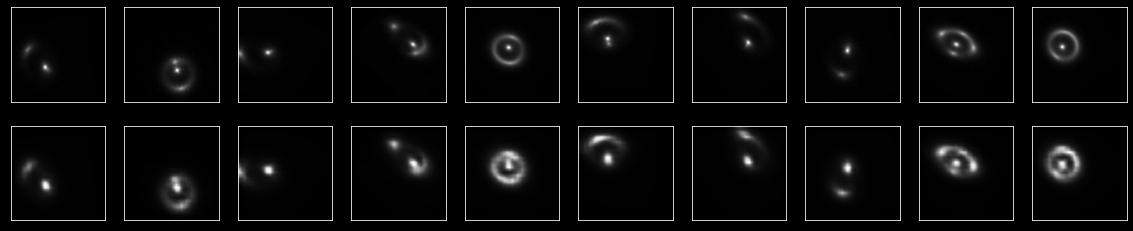

In [42]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test2)
decoded_imgs = decoder.predict(encoded_imgs)
plt.style.use('dark_background')
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test2[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [43]:
#for finding the mean square error 

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [44]:
no_sub_predicted = autoencoder.predict(no_sub)
sub_predicted = autoencoder.predict(sub)

In [46]:
no_sub_predicted[0].shape

(150, 150, 1)

In [48]:
mse(no_sub_predicted[0], no_sub[0])

0.00024006251956419408

In [50]:
mse_no_sub = []
mse_sub = []

for i in range(len(sub_predicted)):
    mse_no_sub.append(mse(no_sub_predicted[i], no_sub[i]))
    mse_sub.append(mse(sub_predicted[i], sub[i]))
    

In [56]:
losses2 = np.array(mse_sub)
losses1= np.array(mse_no_sub)

In [64]:
import math
import seaborn as sns
sns.set()


In [66]:
w = 0.0005
n1 = math.ceil((losses1.max() - losses1.min())/w)
n2 = math.ceil((losses2.max() - losses2.min())/w)
n1

3

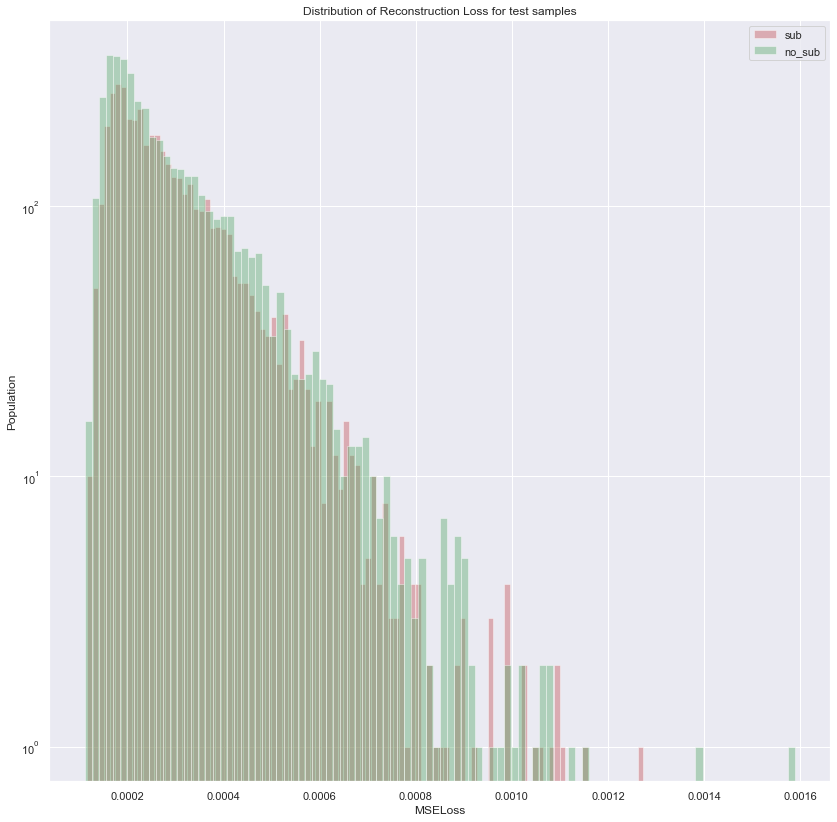

In [74]:
# Plot the distribution of reconstruction loss


sns.distplot(losses2,label='sub',kde=0,norm_hist=0, color="r", bins=100)
sns.distplot(losses1,label='no_sub',kde=0,norm_hist=0, color="g", bins=100)
plt.legend()
plt.xlabel('MSELoss')
plt.ylabel('Population')
# plt.xlim(0,0.01)
plt.yscale('log')
plt.title('Distribution of Reconstruction Loss for test samples')
plt.show()

In [69]:
len(losses1)==len(losses2)

True

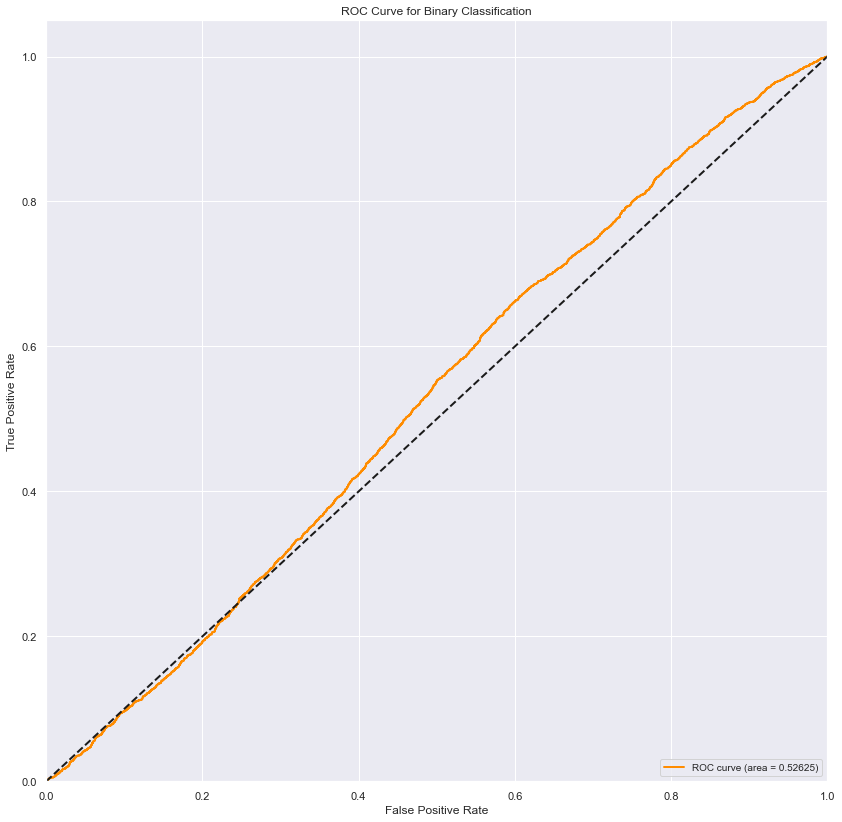

In [75]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
y_ts1 = []
for i in range(losses1.shape[0]):
    y_ts1.append(0)
y_ts1 = np.asarray(y_ts1)
y_ts2 = []
for i in range(losses2.shape[0]):
    y_ts2.append(1)
y_ts2 = np.asarray(y_ts2)

x_ts = np.concatenate((losses1,losses2)).reshape(-1,1)
y_ts = np.concatenate((y_ts1,y_ts2))

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_ts, x_ts)
roc_auc = auc(fpr, tpr)

# Plot the AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right", prop={"size":10})